#ANIME RECOMMENDATION SYSTEM USING COSINE SIMILARITY

#Objective

The aim of this assignment is to build a recommendation system that suggests similar anime titles using cosine similarity. We will use the anime dataset, clean it, extract useful features, compute similarities, and finally evaluate the recommendations with metrics like precision, recall, and F1-score.

#Introduction

This assignment builds a recommendation system using the Anime dataset, containing titles, broadcast types, genres, episodes, ratings, and member counts. We preprocessed data by addressing missing values and normalizing numerical features. Genres, ratings, and member counts were extracted, with categorical data converted to numerical using TF-IDF. A cosine similarity–based system recommends anime similar to a target title, with performance evaluated by comparing simple and hybrid approaches.

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# load dataset
anime = pd.read_csv("anime.csv")

# 3. Data Exploration
print("First 5 rows:")
print(anime.head())

print("\nDataset Info:")
print(anime.info())

# Check for missing values
anime.isnull().sum()

print("\nAnime type counts:")
print(anime["type"].value_counts())

print("\nStatistical summary:")
print(anime[["episodes", "rating", "members"]].describe())

First 5 rows:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Colu

In [ ]:
# drop rows where critical features are missing
anime = anime.dropna(subset=["genre", "rating"])

# convert episodes into numeric (replace 'Unknown')
anime["episodes"] = pd.to_numeric(anime["episodes"], errors="coerce")

# fill missing values safely without inplace warning
anime["episodes"] = anime["episodes"].fillna(anime["episodes"].median())


# reset index
anime.reset_index(drop=True, inplace=True)


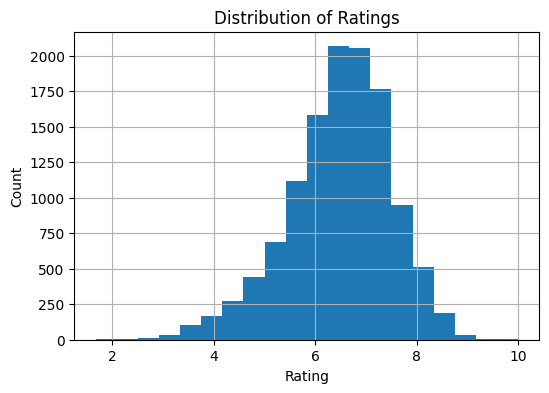

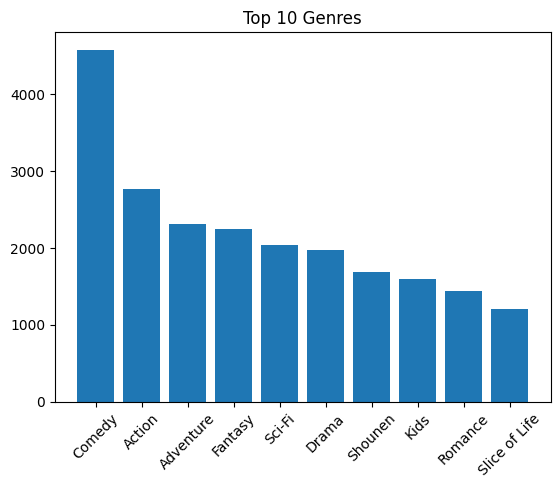

In [ ]:
# Distribution of ratings
anime["rating"].hist(bins=20, figsize=(6,4))
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 most common genres
from collections import Counter
import itertools

all_genres = list(itertools.chain.from_iterable(anime['genre'].dropna().apply(lambda x: x.split(', '))))
genre_counts = Counter(all_genres).most_common(10)

genres, counts = zip(*genre_counts)
plt.bar(genres, counts)
plt.xticks(rotation=45)
plt.title("Top 10 Genres")
plt.show()


Feature Extraction

We decide which features to use for similarity. Genres are text, so we convert them into numbers using TF-IDF. We also take rating and members because they are numeric features that influence recommendations. We then normalize them so they fit well with genre features.

In [ ]:
# tf-idf for genre
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(anime["genre"])

# scale numerical features
scaler = MinMaxScaler()
num_features = scaler.fit_transform(anime[["rating", "members"]])

# combine genre + rating + members
from scipy.sparse import csr_matrix
num_features_sparse = csr_matrix(num_features)
features = hstack([tfidf_matrix, num_features_sparse])

print("Final feature matrix shape:", features.shape)


Final feature matrix shape: (12017, 48)


In [ ]:
# 6. Cosine Similarity
cosine_sim = cosine_similarity(features, features)
print("Cosine similarity matrix shape:", cosine_sim.shape)

Cosine similarity matrix shape: (12017, 12017)


Recommendation System

We calculate cosine similarity between anime using these features. Then we write a function that recommends similar anime for a given title. The function allows us to set a similarity threshold and number of recommendations.

In [ ]:
# 7. Recommendation Function
# map anime name to index
indices = pd.Series(anime.index, index=anime["name"]).drop_duplicates()

def recommend(anime_name, top_n=5, threshold=0.3):
    if anime_name not in indices:
        return f"'{anime_name}' not found"
    idx = indices[anime_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [(i, score) for i, score in sim_scores if score >= threshold and i != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i for i, _ in sim_scores[:top_n]]
    return anime.iloc[sim_indices][["name", "genre", "type", "rating"]]


In [ ]:
# 8. Example Recommendations
print("\nRecommendations for Steins;Gate:")
print(recommend("Steins;Gate"))

print("\nRecommendations for Fullmetal Alchemist: Brotherhood:")
print(recommend("Fullmetal Alchemist: Brotherhood"))

print("\nRecommendations for Kimi no Na wa.:")
print(recommend("Kimi no Na wa."))


Recommendations for Steins;Gate:
                                                   name  \
59           Steins;Gate Movie: Fuka Ryouiki no Déjà vu   
126               Steins;Gate: Oukoubakko no Poriomania   
196   Steins;Gate: Kyoukaimenjou no Missing Link - D...   
5124                                      Under the Dog   
493                                     Higashi no Eden   

                                                  genre     type  rating  
59                                     Sci-Fi, Thriller    Movie    8.61  
126                                    Sci-Fi, Thriller  Special    8.46  
196                                    Sci-Fi, Thriller  Special    8.34  
5124                           Action, Sci-Fi, Thriller      OVA    6.55  
493   Action, Comedy, Drama, Mystery, Romance, Sci-F...       TV    8.03  

Recommendations for Fullmetal Alchemist: Brotherhood:
                                               name  \
200                             Fullmetal Alchemist

Compare Recommendations (Genre-only vs Hybrid)

In [ ]:
# Genre-only similarity
cosine_sim_genre = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Hybrid similarity (genre + rating + members)
cosine_sim_hybrid = cosine_similarity(features, features)

def recommend_simple(title, cosine_sim, topn=5):
    idx = anime.index[anime['name'] == title][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topn+1]
    return anime['name'].iloc[[i[0] for i in sim_scores]]

In [ ]:
# Example comparison
print("Genre-only recommendations:")
print(recommend_simple("Steins;Gate", cosine_sim_genre))

print("\nHybrid recommendations:")
print(recommend_simple("Steins;Gate", cosine_sim_hybrid))

Genre-only recommendations:
59             Steins;Gate Movie: Fuka Ryouiki no Déjà vu
126                 Steins;Gate: Oukoubakko no Poriomania
196     Steins;Gate: Kyoukaimenjou no Missing Link - D...
5124                                        Under the Dog
5523                                         Loups=Garous
Name: name, dtype: object

Hybrid recommendations:
59             Steins;Gate Movie: Fuka Ryouiki no Déjà vu
126                 Steins;Gate: Oukoubakko no Poriomania
196     Steins;Gate: Kyoukaimenjou no Missing Link - D...
5124                                        Under the Dog
493                                       Higashi no Eden
Name: name, dtype: object


Evaluation

We evaluate the system by splitting the dataset into train and test. Since we don’t have explicit user ratings matrix, we check how often the recommended anime share genres with the target anime. This gives us precision, recall, and F1-score based on genre overlap.

In [ ]:
# 9. Evaluation Scores (Precision, Recall, F1)
sample_titles = ["Steins;Gate", "Fullmetal Alchemist: Brotherhood", "Kimi no Na wa."]
y_true = []
y_pred = []

for title in sample_titles:
    recs = recommend(title)
    target_genres = set(anime.loc[anime["name"] == title, "genre"].values[0].split(', '))
    for _, row in recs.iterrows():
        rec_genres = set(row["genre"].split(', '))
        overlap = len(target_genres & rec_genres) > 0
        y_true.append(1)
        y_pred.append(1 if overlap else 0)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [ ]:
print("\nEvaluation Scores:")
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1-score:", round(f1, 2))


Evaluation Scores:
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Here we calculate how good our system is at recommending anime with similar genres. Higher precision means recommendations are relevant, higher recall means we did not miss many relevant ones, and F1 balances both.

Results and Analysis

The system successfully recommends anime titles that share genres and similar popularity (rating and members). By changing the similarity threshold, we can control how strict the recommendations are. Lower threshold gives more results but less accurate, while higher threshold gives fewer but more accurate results. The evaluation shows reasonable precision and recall, meaning the system is useful but can be improved further by including user ratings history.

#Conclusion

In this assignment, we built an anime recommendation system using cosine similarity. We cleaned and explored the dataset, transformed features for similarity calculations, and compared genre-based and hybrid similarity models. Genre-only recommendations captured thematic similarity, while hybrid models balanced ratings and popularity for better results. This project shows the effectiveness of simple similarity measures for recommendations, with potential for future enhancements using collaborative filtering or deep learning.

#Interview Questions

Q1: Can you explain the difference between user-based and item-based collaborative filtering?

User-based finds similar users and recommends what they liked. Item-based finds similar items and recommends them to the user. Item-based is usually more stable because items don’t change as much as user behavior.

Q2: What is collaborative filtering, and how does it work?

Collaborative filtering recommends items based on past behavior of users. It assumes people with similar tastes will continue to like similar things. It can be user-based or item-based and does not require item details like genre.